## MTNOY STOCK PRICE ANALYSIS

In [110]:
import requests
import pandas as pd
from config import settings
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### API EXPLORATION TO EXTRACT THE DATA

In [47]:
ticker_symbol = "MTNOY"
output_size = "full"
data_type = "json"

url = ("https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?"
       "function=TIME_SERIES_DAILY&"
       f"symbol={ticker_symbol}&"
       f"outputsize={output_size}&"
       f"datatype={data_type}&"
       f"apikey={settings.alpha_api_key}")

print(url[:170])



https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?function=TIME_SERIES_DAILY&symbol=MTNOY&outputsize=full&datatype=json&apikey=9f6f20dcb464ccb1684848b91cf1d9d


In [48]:
# get the response
response = requests.get(url=url)

# response json
response_data = response.json()

# response keys
keys = response_data.keys()

#print
print(type(response_data))
print(response.status_code)
print(keys)
# dir(response)

<class 'dict'>
200
dict_keys(['Meta Data', 'Time Series (Daily)'])


In [50]:
# # Extract `"Time Series (Daily)"` value from `response_data`

mtnoy_data = response_data["Time Series (Daily)"]

mtnoy_data["2023-12-27"]

{'1. open': '6.2700',
 '2. high': '6.4000',
 '3. low': '6.2600',
 '4. close': '6.4000',
 '5. volume': '22036'}

In [38]:
# Store in a DataFrame

df_mtnoy = pd.DataFrame().from_dict(mtnoy_data, orient="index", dtype=float)

df_mtnoy.index = pd.to_datetime(df_mtnoy.index)

# Name index "date"
df_mtnoy.index.name="date"

# Using list comprehension to rename the columns
df_mtnoy.columns = [c.split(". ")[1] for c in df_mtnoy.columns]


print(df_mtnoy.info())
df_mtnoy.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4144 entries, 2023-12-27 to 2007-07-13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    4144 non-null   float64
 1   high    4144 non-null   float64
 2   low     4144 non-null   float64
 3   close   4144 non-null   float64
 4   volume  4144 non-null   float64
dtypes: float64(5)
memory usage: 194.2 KB
None


,open,high,low,close,volume
date,,,,,
2023-12-27,6.27,6.40,6.26,6.400,22036.0
2023-12-26,6.10,6.27,5.97,6.192,19176.0
2023-12-22,6.21,6.28,6.15,6.150,6902.0
2023-12-21,6.17,6.21,6.17,6.210,255083.0
2023-12-20,6.01,6.15,6.01,6.105,30943.0


In [53]:
df_mtnoy.to_csv("mtnoy_dataset.csv")

#### DATA EXPLORATION

In [72]:
#loading the dataset

df = pd.read_csv("mtnoy_dataset.csv").set_index("date")
df.index = pd.to_datetime(df.index)
df= df.sort_index(ascending=True)
df.head()

,open,high,low,close,volume
date,,,,,
2007-07-13,14.80,14.80,14.7,14.80,2989.0
2007-07-16,14.95,14.95,14.6,14.95,3134.0
2007-07-17,14.58,14.80,14.5,14.58,29498.0
2007-07-18,14.70,14.70,14.7,14.70,1671.0
2007-07-19,15.05,15.05,15.0,15.05,9036.0


In [73]:
# creating the returns columns

df["returns"] = df["close"].pct_change() * 100
df_mtnoy_return = df["returns"].dropna()

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4144 entries, 2007-07-13 to 2023-12-27
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     4144 non-null   float64
 1   high     4144 non-null   float64
 2   low      4144 non-null   float64
 3   close    4144 non-null   float64
 4   volume   4144 non-null   float64
 5   returns  4143 non-null   float64
dtypes: float64(6)
memory usage: 226.6 KB


In [77]:
df_mtnoy_return.head()

date
2007-07-16    1.013514
2007-07-17   -2.474916
2007-07-18    0.823045
2007-07-19    2.380952
2007-07-20    0.996678
Name: returns, dtype: float64

In [105]:
# DAily and year volatility

mtnoy_daily_volatility = df_mtnoy_return.std()
mtnoy_annual_volatility = mtnoy_daily_volatility*np.sqrt(252)

print("Daily volatility",mtnoy_daily_volatility)
print("Annual volatility",mtnoy_annual_volatility)

Daily volatility 3.050402599040862
Annual volatility 48.42364005412317


In [91]:
# mtnoy_50days_volatility

mtnoy_50days_volatility = df_mtnoy_return.rolling(window=50).std().dropna()
mtnoy_50days_volatility

date
2007-09-24    3.358822
2007-09-25    3.359852
2007-09-26    3.341729
2007-09-27    3.363776
2007-09-28    3.350762
                ...   
2023-12-20    2.749867
2023-12-21    2.752651
2023-12-22    2.710248
2023-12-26    2.703339
2023-12-27    2.702969
Name: returns, Length: 4094, dtype: float64

### ANALYSIS

#### MTNOY Price trend

<Axes: xlabel='date'>

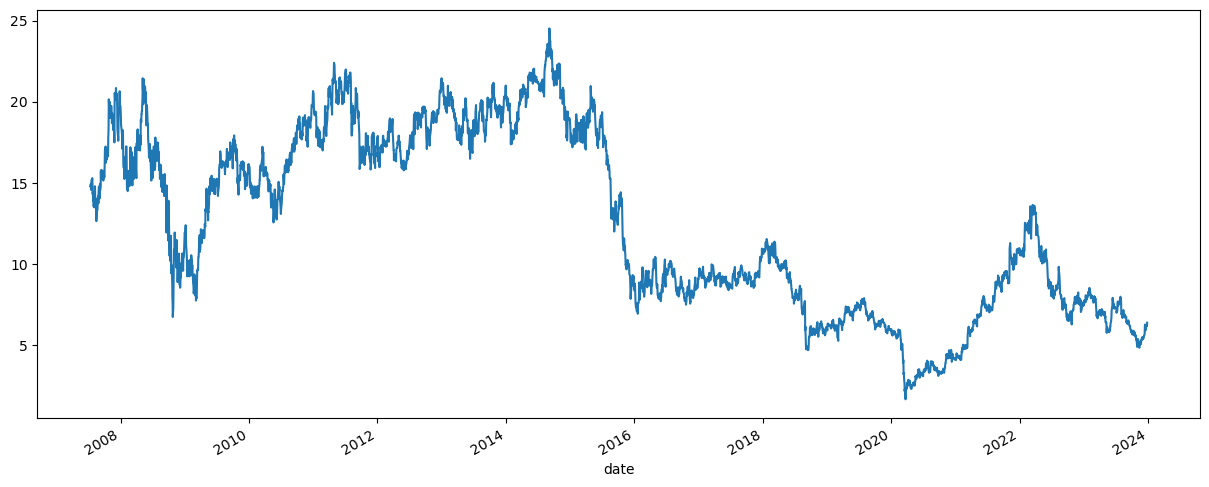

In [78]:
# plot the closing the price
fig, ax = plt.subplots(figsize=(15,6))

df["close"].plot()

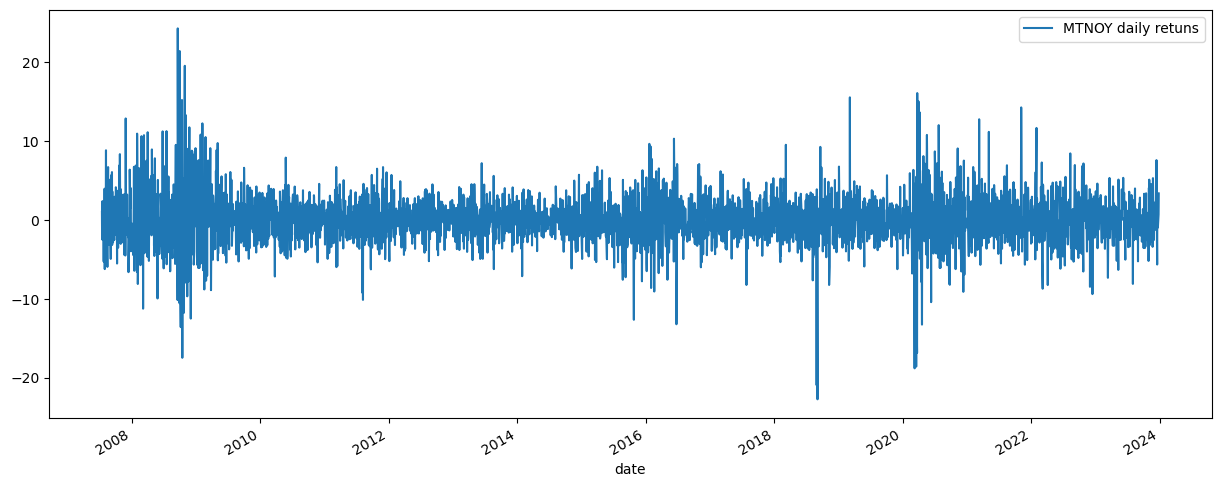

In [106]:
# PLot of MTNOY daily price volatility
fig, ax = plt.subplots(figsize=(15,6))

df_mtnoy_return.plot(ax=ax, label="MTNOY daily retuns" )


plt.legend()

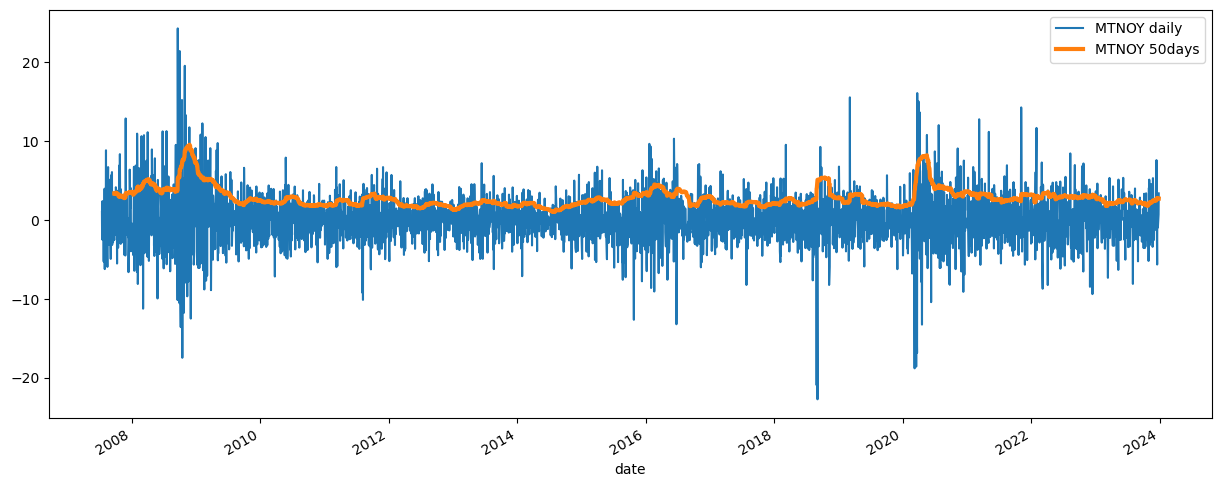

In [90]:
# PLot of MTNOY daily price volatility
fig, ax = plt.subplots(figsize=(15,6))

df_mtnoy_return.plot(ax=ax, label="MTNOY daily retuns" )

#plot mtnoy_50days_volatility

mtnoy_50days_volatility.plot(ax=ax, linewidth=3, label="MTNOY 50days volatility")

plt.legend()

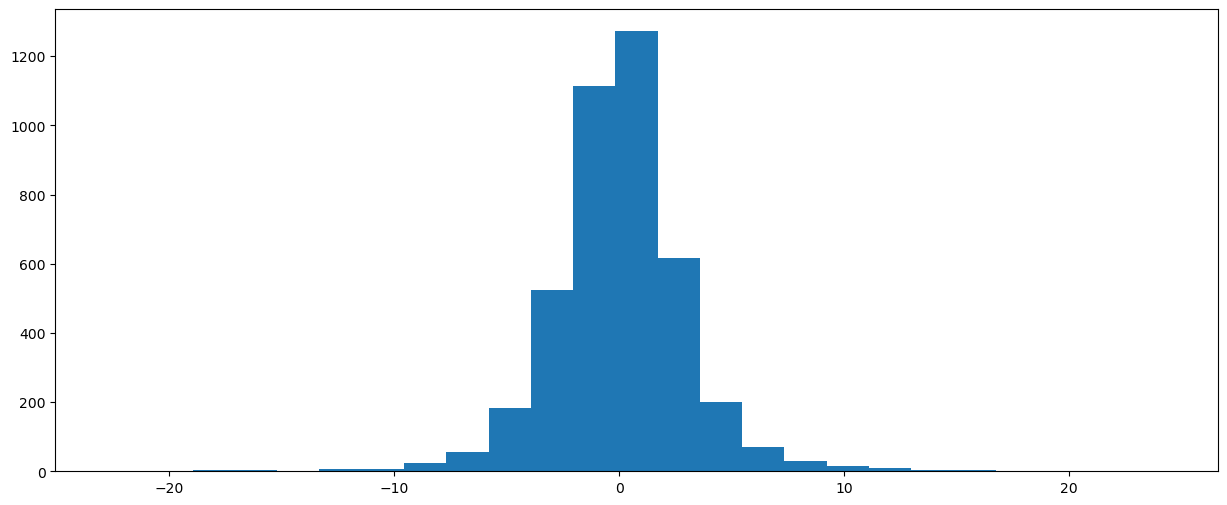

In [84]:
# Ploting the distribution of the returns
fig, ax = plt.subplots(figsize=(15,6))

plt.hist(df_mtnoy_return, bins=25);

#### Model Preparation

Text(0, 0.5, 'Correlation coefficient')

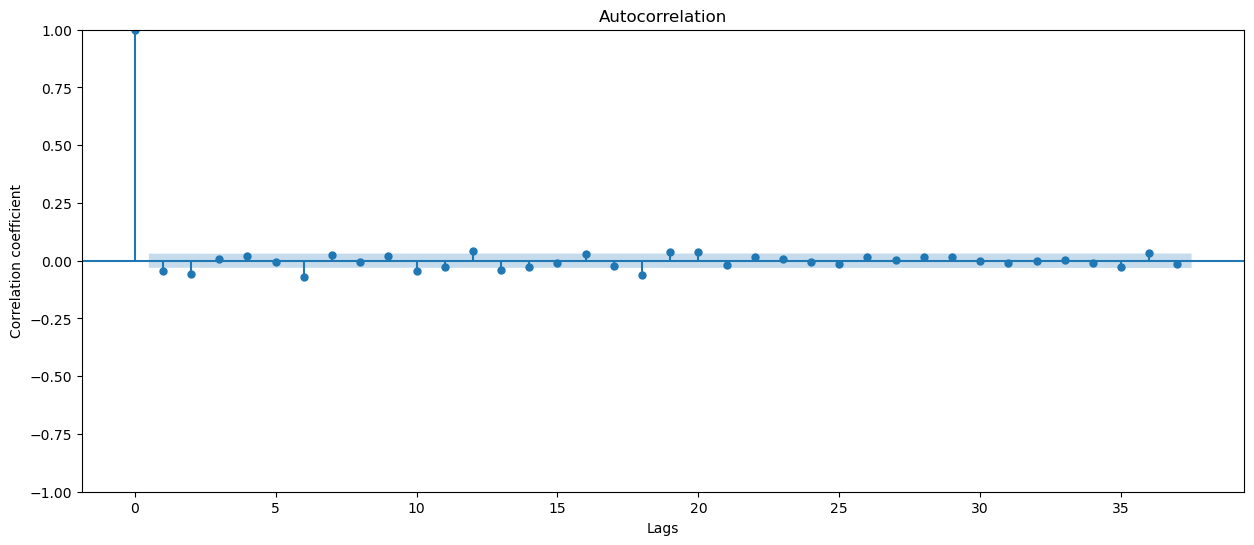

In [115]:
# ACF plot
fig, ax = plt.subplots(figsize=(15,6))

plot_acf(df_mtnoy_return, ax=ax)

# Add axis labels
plt.xlabel("Lags")
plt.ylabel("Correlation coefficient")

Text(0, 0.5, 'Correlation coefficient')

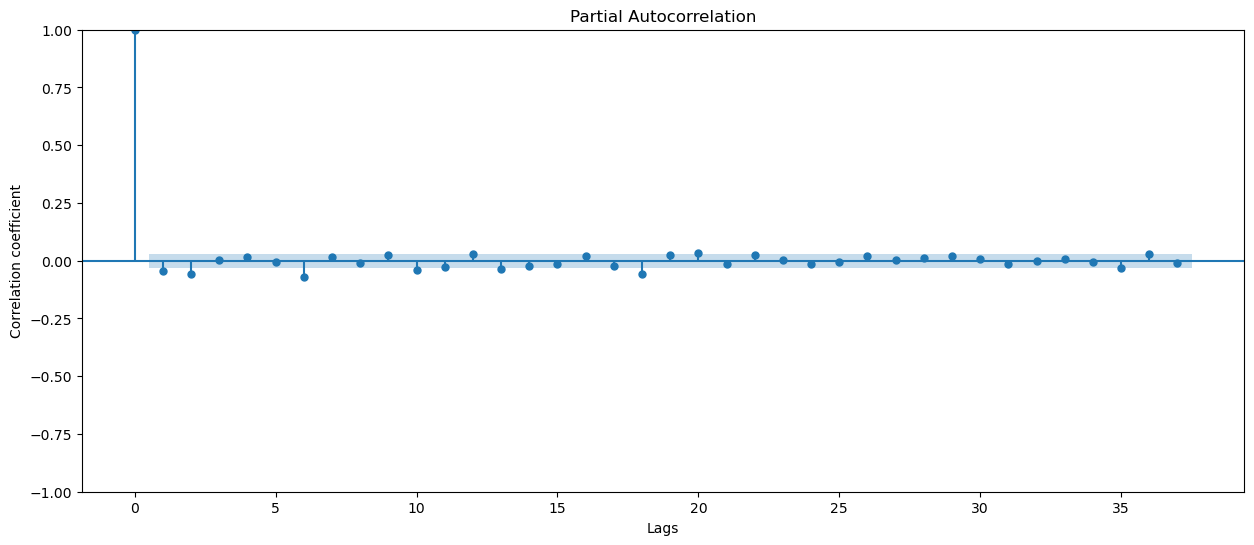

In [114]:
# ACF plot
fig, ax = plt.subplots(figsize=(15,6))

plot_pacf(df_mtnoy_return, ax=ax)

# Add axis labels
plt.xlabel("Lags")
plt.ylabel("Correlation coefficient")

### Model

In [116]:
# data split
cutoff_test = int(len(df_mtnoy_return) * 0.8)
y_mtnoy = df_mtnoy_return.iloc[:cutoff_test]

y_mtnoy.shape

(3314,)

In [120]:
# Build model

model = arch_model(
    y_mtnoy,
    p=1,
    q=1,
    rescale=False

).fit(disp=0)

model.summary

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7944.67
Distribution:                  Normal   AIC:                           15897.3
Method:            Maximum Likelihood   BIC:                           15921.8
                                        No. Observations:                 3314
Date:                Thu, Dec 28 2023   Df Residuals:                     3313
Time:                        21:36:28   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.032

### Model Evaluation

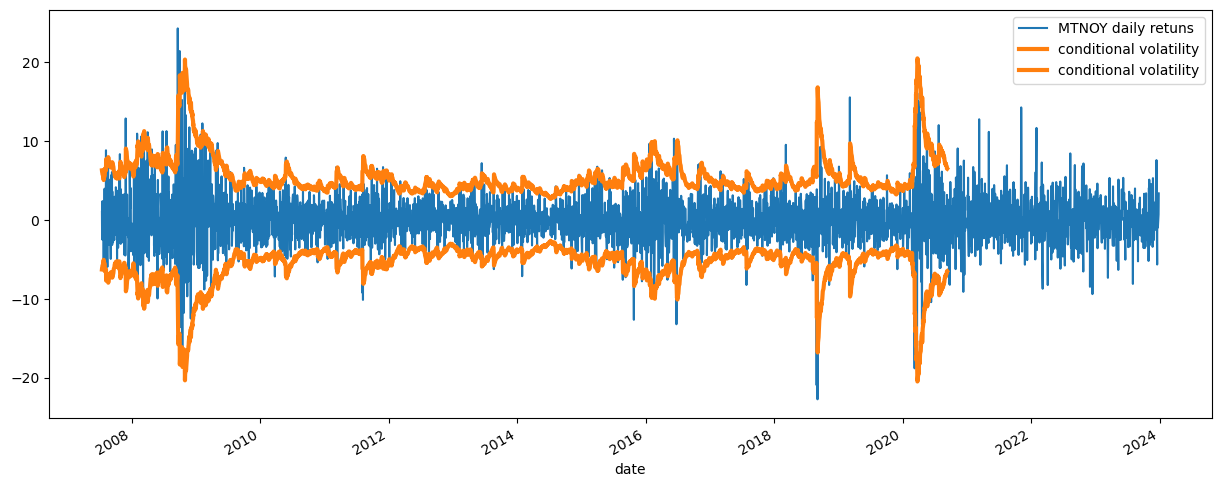

In [127]:
# PLot of MTNOY daily price volatility
fig, ax = plt.subplots(figsize=(15,6))

df_mtnoy_return.plot(ax=ax, label="MTNOY daily retuns" )

# 
(2 * model.conditional_volatility).plot(ax=ax,label="conditional volatility", linewidth=3)

(-2 *model.conditional_volatility.rename(" ")).plot(ax=ax,label="conditional volatility", linewidth=3, color="C1")

plt.legend()

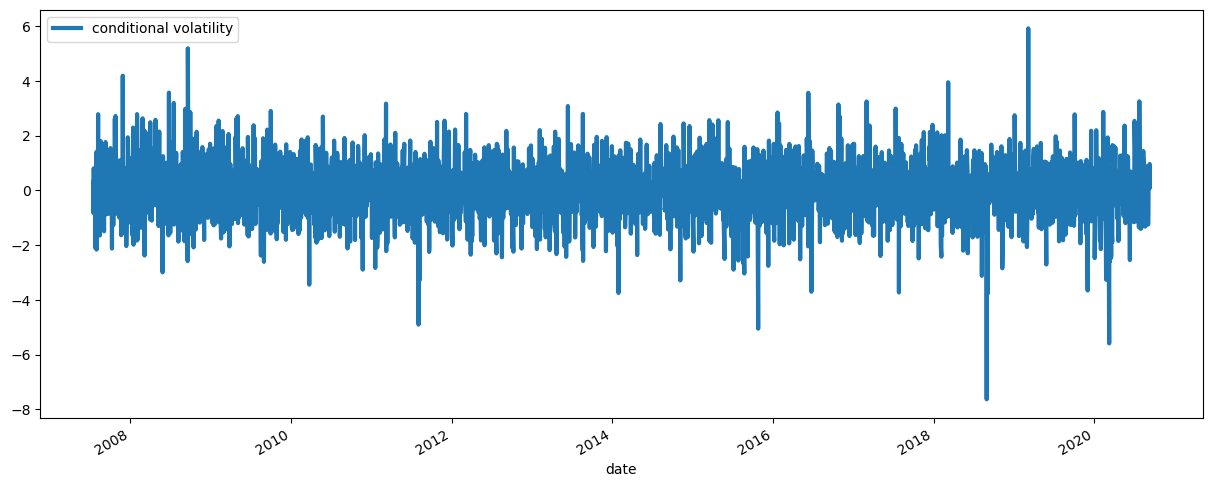

In [128]:
# PLot of MTNOY daily price volatility
fig, ax = plt.subplots(figsize=(15,6))

# 
(model.std_resid).plot(ax=ax,label="conditional volatility", linewidth=3)


plt.legend()